Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.metrics import r2_score,accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV 
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.shape

(354369, 16)

Датасет содержит 9  категориальных , 6 числовых признаков и 1 целевую переменную.   

В первую очередь посмотрим на признаки относящиеся к датам .Всего их 5 -  это:

 - год регистрации авто , 
 - месяц регистрации авто,
 - дата скачивания анкеты из базы, 
 - дата создания анкеты ,
 - дата последней активности пользователя. 
 
На цену автомобиля влияет только признаки указывающие на возраст автомобиля. Как определить возраст автомобиля при продаже , если у нас на руках 'исторические данные'?

Предположим что дата создания анкеты это и есть дата продажи, а дата производства - дата регистрации автомобиля. 
Тогда разница между  датами и будет возрастом автомобиля. Можно выделить признак  - время (длительность) продажи автомобиля (как разницу между датой создания и датой последней активностью клиента). Но задача сервиса определить стоимость автомбиля по входным параметрам. Длительность продажи это уже выходной параметр.

Датой скачивания анкеты и  дата последней активности пользователя пренебрежем.

In [6]:
df['RegistrationYear'].unique()#посмотрим на значения года регистрации

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

В наборе есть нереальные даты (например 7500). Оценим объем данных с датами старше 1900 и младше 2020 

In [7]:
df.query('RegistrationYear<1900 or RegistrationYear>2020').shape

(171, 16)

Таких строк всего 171. Объем незначительный, им можно пожертвовать. 

In [8]:
df = df.loc[(df['RegistrationYear']>1900)&(df['RegistrationYear']<2020)]

Посмотрим на данные месяца регистрации 

In [9]:
df['RegistrationMonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [10]:
df['RegistrationMonth'].value_counts()

0     37220
3     34368
6     31501
4     29266
5     29149
7     27210
10    26098
12    24287
11    24184
9     23811
1     23214
8     22626
2     21264
Name: RegistrationMonth, dtype: int64

Присутствует месяц  обозначенный как 0. Скорее всего это пропуск. Заменим нули на случайный месяц в году. А так же объединим год и месяц в один признак.

In [11]:
df['RegistrationMonth'] = df['RegistrationMonth'].apply(lambda x:  np.random.randint(1,12) if (x==0) else x)
df['Date']=pd.to_datetime(df.loc[:,['RegistrationMonth','RegistrationYear']].astype(str).add(' ').sum(1))

Вычеслим возраст автомобиля и создадим новый признак 'Age'

In [12]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y.%m.%d')
df['Age'] = round((df['DateCreated']-df['Date']).dt.days/365,1)

Удалим остальные даты. 

Колонки с количеством фотографий и почтовым индексом не влияет на цену автомобиля, удалим и их. 

In [13]:
df.set_index('Date', inplace = True)
df.drop(['RegistrationMonth','RegistrationYear','DateCrawled','DateCreated','LastSeen','NumberOfPictures','PostalCode'], axis = 1 , inplace = True)

In [14]:
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Age
Date,,,,,,,,,,
1993-06-01,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,22.8
2011-05-01,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,4.9
2004-08-01,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,11.6


Изучим  пропуски

In [15]:
df.isna().sum()

Price              0
VehicleType    37319
Gearbox        19695
Power              0
Model          19630
Kilometer          0
FuelType       32767
Brand              0
NotRepaired    71007
Age                0
dtype: int64

Начнем с признака NotRepaired - 'была машина в ремонте или нет'

In [16]:
df['NotRepaired'].value_counts()

no     247146
yes     36045
Name: NotRepaired, dtype: int64

И так у признака всего два значения - да и нет. Но легко себе представить что продавец не знает была ли его машина в ремонте или нет. Например второй владелец, который не проверил данный параметр у первого(и т.д. и т.п.) . Заменим пропуски на UNK

In [17]:
df['NotRepaired']= df['NotRepaired'].fillna('UNK')

Пропуски в остальных признаках имеют существенное значение на цену автомобиля. Это тип кузова, коробка передач, модель и тип топлива.
Замену в данных признаках проведем по принципу наиболее частовстречаемых значений (МОДА) среди подобных автомобилей. Подобие будет определятся по 
таким признакам как:
    - Бренд
    - Модель
    - Тип кузова


Проведем замены пропусков в данных по модели. 

In [18]:
#создадим список мод model_mode  и заменим пропуски модами, если производитель имеет все пропущенные значения в названиях модели, заменим 
#пропуск на 'UNK'
model_mode = df.groupby(['Brand'])['Model'].apply(lambda x: x.mode()[0] if x.count()!=0 else 'UNK')
#функция заполняет пропуски из списка 
def filler_M(row):
    if type(row['Model']) !=str:
        return model_mode.get(row['Brand'],row['VehicleType'])
    return row['Model']
df['Model'] = df.apply(filler_M, axis =1)
#посчитатем итоговое кол-во пропусков
df['Model'].isna().sum()

0

По тому же принципу заменим пропуски в остальных категориальных  признаках. 

In [19]:
#признак 'VehicleType'
VehicleType_mode = df.groupby(['Brand','Model'])['VehicleType'].apply(lambda x:  x.mode()[0] if x.count()!=0 else 'UNK').to_dict()
def filler_V(row):
    if type(row['VehicleType']) !=str:
        return VehicleType_mode.get((row['Brand'],row['Model']))
    return row['VehicleType']
df['VehicleType'] = df.apply(filler_V, axis =1)
df['VehicleType'].isna().sum()

0

In [20]:
# признак 'Gearbox_mode'
Gearbox_mode = df.groupby(['Brand','Model','VehicleType'])['Gearbox'].apply(lambda x:  x.mode()[0] if x.count()!=0 else 'UNK'
                                                                     ).to_dict()
def filler_G(row):
    if type(row['Gearbox']) !=str:
        return Gearbox_mode.get((row['Brand'],row['Model'],row['VehicleType']))
    return row['Gearbox']
df['Gearbox'] = df.apply(filler_G, axis =1)
df['Gearbox'].isna().sum()

0

In [21]:
# признак 'FuelType_mode'
FuelType_mode = df.groupby(['Brand','Model','VehicleType'])['FuelType'].apply(lambda x:  x.mode()[0] if x.count()!=0 else 'UNK'
                                                                     ).to_dict()
def filler_F(row):
    if type(row['FuelType']) !=str:
        return FuelType_mode.get((row['Brand'],row['Model'],row['VehicleType']))
    return row['FuelType']
df['FuelType'] = df.apply(filler_F, axis =1)
df['FuelType'].isna().sum()

0

In [22]:
df.isna().sum()

Price          0
VehicleType    0
Gearbox        0
Power          0
Model          0
Kilometer      0
FuelType       0
Brand          0
NotRepaired    0
Age            0
dtype: int64

И так пропусков не осталось
Приступим к числовым признакам

In [23]:
df.describe()

,Price,Power,Kilometer,Age
count,354198.000000,354198.000000,354198.000000,354198.000000
mean,4417.651314,110.078242,128267.607383,12.697942
std,4514.081022,189.536766,37823.538557,7.550824
min,0.000000,0.000000,5000.000000,-3.700000
25%,1050.000000,69.000000,125000.000000,8.200000
50%,2700.000000,105.000000,150000.000000,12.700000
75%,6400.000000,143.000000,150000.000000,16.900000
max,20000.000000,20000.000000,150000.000000,106.300000


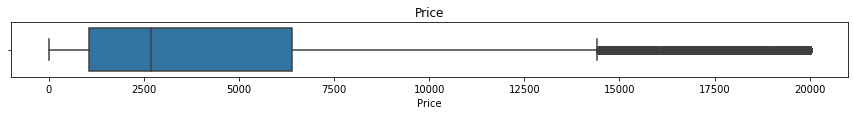

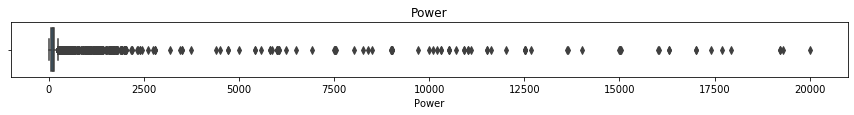

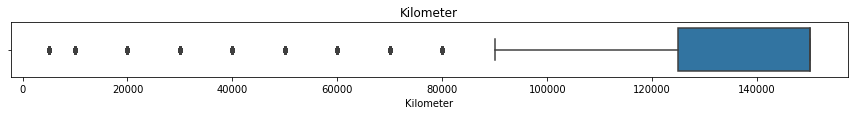

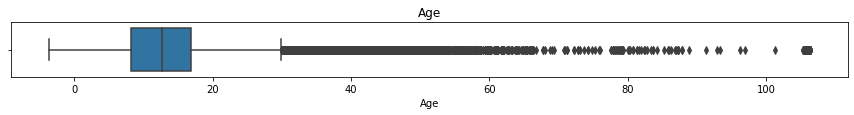

In [34]:
tmp1=['Price','Power','Kilometer','Age']
for order in tmp1:
    plt.figure(figsize=(15,1))
    sns.boxplot(df[order],  orient="h")
    plt.title(order)

У нас есть аномальные значения в числовых признаках в мощности двигателя, возрасте и в цене. Посмотрим и оценим их.

Начнем с мощности. Посмотрим на значения. 

In [35]:
df['Power'].value_counts()

0       40098
75      24020
60      15897
150     14590
101     13298
        ...  
1360        1
1968        1
6226        1
337         1
6006        1
Name: Power, Length: 711, dtype: int64

В мощности двигателя 40k значений равно нулю. Скорее всего это пропуск. Воспользуемся уже знакомым методом и заменим нули
на значения  подобных автомобилей. Строки с мощностью двигателя более 1k л.с. удалим. 

In [36]:
Power_mode = df.groupby(['Brand','Model'])['Power'].median().to_dict()
def filler_P(row):
    if row['Power'] == 0:
        return Power_mode.get((row['Brand'],row['Model']))
    return row['Power']
df['Power'] = df.apply(filler_P, axis =1)


In [37]:
df['Power'].value_counts()

75.0       25723
60.0       21803
90.0       17880
101.0      15559
150.0      14903
           ...  
323.0          1
1922.0         1
13616.0        1
68.5           1
1239.0         1
Name: Power, Length: 721, dtype: int64

Нормальное распределение по мощности укладывается в диапозон до 250 л.с. Можно представить реальные двигатели до 1000 л.с.
Но свыше это уже фантастика. Удалим их. 

In [38]:

df = df.loc[df['Power']<1000]

In [39]:
df.shape

(353899, 10)

Посмотрим на количество автомобилей с нулевой ценой.

In [40]:
df.loc[df['Price']<=0].shape

(10725, 10)

Это явная аномалия, такого количества обьявлений по нулевой цене не встречается на сайтах. Скорее всего данные утеряны на этапе сбора. Так как это целевой признак , мы не можем его редактировать
Удалим аномалии.

In [41]:
df = df.loc[df['Price']>0]
df.shape

(343174, 10)

### КОДИРОВАНИЕ

Для линейной регресии необходимо закодировать категориальные признаки. Заменим значения простыми числами, обозначающими порядковый номер данного значения в общем списке

In [42]:
categorical = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']
l = 0
tmp = []
for cat in categorical:
    tmp = df[cat].unique()
    l = [i for i in range(len(tmp))]
    tmp = dict(zip(tmp, l))
    df[cat] = df[cat].map(tmp)


In [43]:
df.head(3)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Age
Date,,,,,,,,,,
1993-06-01,480,0,0,90.0,0,150000,0,0,0,22.8
2011-05-01,18300,1,0,190.0,1,125000,1,1,1,4.9
2004-08-01,9800,2,1,163.0,2,125000,1,2,0,11.6


Посчитаем количество дублакатов

In [44]:
df.duplicated().sum()

26156

In [45]:
df.shape

(343174, 10)

In [46]:
df.drop_duplicates(inplace = True)

In [47]:
df.shape

(317018, 10)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 317018 entries, 1993-06-01 to 2002-06-01
Data columns (total 10 columns):
Price          317018 non-null int64
VehicleType    317018 non-null int64
Gearbox        317018 non-null int64
Power          317018 non-null float64
Model          317018 non-null int64
Kilometer      317018 non-null int64
FuelType       317018 non-null int64
Brand          317018 non-null int64
NotRepaired    317018 non-null int64
Age            317018 non-null float64
dtypes: float64(2), int64(8)
memory usage: 26.6 MB


Мы провели предобработку данных. Синтезировали из имеющихся данных очень важный для цены автомобиля признак  - его возраст. 
Заменили пропуски в категориальных признаках, почистили аномалии.Удалили лишние признаки. Перейдем к обучению моделей

# 2. Обучение моделей

Разобьем датасет на обучающую и тестовую выборки

In [49]:
X = df.drop(['Price'], axis=1)
Y = df['Price']
X_train, X_test,Y_train, Y_test  = train_test_split(X,Y,  test_size=0.20, random_state=12345)
categorical = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand', 'NotRepaired']

### Линейная регрессия 

In [50]:
logres =  LinearRegression()
#Начнем считать время
start_time = time.time()
logres.fit(X_train, Y_train)
predicted_valid = logres.predict(X_test)
time_train_lr = time.time() - start_time
mse = mean_squared_error(Y_test, predicted_valid)
print("RMSE =", mse ** 0.5)
print("Время обучения LinearRegression:", time_train_lr)

RMSE = 3130.9375981377257
Время обучения LinearRegression: 0.0911259651184082


### LightGBM

In [66]:
train_lgb = lgb.Dataset(X_train, Y_train)
valid_lgb = lgb.Dataset(X_test, Y_test)

param_lgb = {'objective': 'regression', 
             'learning_rate': 0.5, 
             'subsample' : 0.8, 
             'max_depth': 8, 
             'metric': 'rmse'}

#Начнем считать время
start_time = time.time()
model_lgb = lgb.train(params=param_lgb, 
                      train_set=train_lgb,
                      num_boost_round=1000,
                      valid_sets=[valid_lgb, train_lgb], 
                      valid_names=['test', 'train'], 
                      early_stopping_rounds=50, 
                      verbose_eval=50)

time_train_lightgb = time.time() - start_time
models_timings['LightGBM'] = time_train_lightgb
print("Время обучения LightGBM:", time_train_lightgb)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 1693.3	test's rmse: 1741.84
[100]	train's rmse: 1618.27	test's rmse: 1711.66
[150]	train's rmse: 1559	test's rmse: 1690.71
[200]	train's rmse: 1520.97	test's rmse: 1680.17
[250]	train's rmse: 1488.32	test's rmse: 1672.07
[300]	train's rmse: 1461.88	test's rmse: 1668.72
[350]	train's rmse: 1438.68	test's rmse: 1665
[400]	train's rmse: 1419.55	test's rmse: 1663.29
[450]	train's rmse: 1401.83	test's rmse: 1664.79
Early stopping, best iteration is:
[405]	train's rmse: 1417.44	test's rmse: 1662.83
Время обучения LightGBM: 38.0419921875


# 3. Анализ моделей

Линейная регрессия имеет серьезную ошибку
RMSE = 3130.9375981377257
при этом скорость обучения модели высокая - 0.09

Градиентный бустинг LightGBM - предсказывает гораздо лучше 
RMSE = 1662.8
При это время обучения существенно выше  - 38.04